In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import os
from PIL import Image
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F 

In [2]:
def test(test_loader,model,direct):
    print('Resume model: %s' % direct)
    model_test = model.to(computing_device)
    check_point = torch.load(direct)
    model_test.load_state_dict(check_point['state_dict'])
    output_all = []
    labels_all = []
    
    for mb_count, (test_images, test_labels) in enumerate(test_loader, 0):
        with torch.no_grad():      
            test_images, test_labels = test_images.to(computing_device), test_labels.to(computing_device)
            test_images = torch.squeeze(torch.stack([test_images,test_images,test_images], dim=1, out=None))
            outputs = model_test(test_images)
        print(mb_count)
        outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        test_labels = np.argmax(test_labels.cpu().detach().numpy(),axis=1)
        output_all.append(list(outputs))
        labels_all.append(list(test_labels))   
    print("test finish")
    return output_all, labels_all


In [3]:
from plankton_dataloader import create_split_loaders

# Setup: initialize the hyperparameters/variables
num_epochs = 1           # Number of full passes through the dataset
batch_size = 128          # Number of samples in each minibatch
learning_rate = 0.001  
seed = np.random.seed(0) # Seed the random number generator for reproducibility
p_val = 0.1              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing

#TODO: Convert to Tensor - you can later add other transformations, such as Scaling here
transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.ToPILImage('L'),
        transforms.Resize([224,224],interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")





CUDA is supported


In [4]:
root_dir = "../dataset/data_subset/"
# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(root_dir,batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

In [5]:
direct = './checkpoint/9_model_epoch80.pth'
import torchvision.models as models
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(nn.Linear(512, 121))
model = model.to(computing_device)
outputall, labelall = test(test_loader,model,direct)

Resume model: ./checkpoint/9_model_epoch80.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
test finish


In [6]:
def load_label_matrix(label_dir = "labels.txt"):
    f = open(label_dir,"r")
    # And for reading use
    classes = f.read()
    f.close()
    classes_list = classes.split('\n')

    label_list = classes_list[1::2]
    return label_list


In [7]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    lab = np.argmax(labels, axis=1)
    return np.sum(outputs==lab)/float(lab.size)

In [95]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 12)

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()




In [9]:
labelall = [item for sublist in labelall for item in sublist]
outputall = [item for sublist in outputall for item in sublist]

In [10]:
labelall = np.array(labelall)
outputall = np.array(outputall)

In [ ]:
# Compute confusion matrix
# cnf_matrix = confusion_matrix(labelall,outputall)
# np.set_printoptions(precision=2)

# class_names = load_label_matrix()
# # Plot normalized confusion matrix
# plt.figure(figsize=(20,20))
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [ ]:
# import seaborn as sns;
# plt.figure(figsize=(20,20))
# sns.heatmap(cnf_matrix)

In [13]:
len(set(labelall))

120

In [14]:
# Save confusion matrix to csv file
cnf_matrix = confusion_matrix(labelall,outputall)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
cnf_matrix.shape
# np.savetxt('test.csv', cnf_matrix, delimiter=',', fmt='%s')

(120, 120)

### Only consider the top-10 and bottom-10 most accurate classification

In [32]:
diag_cnf_matrix = cnf_matrix.diagonal()
top_10 = diag_cnf_matrix.argsort()[-10:][::-1]
bottom_10 = diag_cnf_matrix.argsort()[0:5]
class_names = load_label_matrix()
for idx in top_10:
    print(diag_cnf_matrix[idx])

1.0
1.0
1.0
1.0
0.9818181818181818
0.981651376146789
0.9782608695652174
0.9767441860465116
0.96875
0.9682539682539683


In [18]:
filtered_class_names = list()
new_class_name_map = dict()

for i in range(len(class_names)):
    if (i in set(labelall)):
        filtered_class_names.append(class_names[i])
    else:
        indent_num = i
        print(i)
len(filtered_class_names)

21


120

#### Confusion Matrix for Top-10 Correct Classification

In [80]:
considered_classes = sorted(set(top_10))
print(considered_classes)
for i in range(len(considered_classes)):
    if considered_classes[i] >= indent_num:
        considered_classes[i] += 1
        
considered_classes

[29, 51, 66, 70, 72, 76, 78, 90, 101, 111]


[30, 52, 67, 71, 73, 77, 79, 91, 102, 112]

In [102]:
class_names_top_10

['hydromedusae_haliscera',
 'echinoderm_larva_seastar_brachiolaria',
 'hydromedusae_typeD_bell_and_tentacles',
 'artifacts',
 'copepod_cyclopoid_oithona_eggs',
 'tornaria_acorn_worm_larvae',
 'tunicate_partial',
 'protist_fuzzy_olive',
 'chordate_type1',
 'acantharia_protist',
 'All others']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.9783 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.0217]
 [0.     0.9767 0.     0.     0.     0.     0.     0.     0.     0.
  0.0233]
 [0.     0.     1.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.9817 0.     0.     0.     0.     0.
  0.0183]
 [0.     0.     0.     0.     0.     1.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.9683 0.     0.     0.
  0.0317]
 [0.     0.     0.     0.     0.     0.     0.     0.9688 0.     0.
  0.0312]
 [0.     0.     0.     0.     0.     0.     0.     0.     1.     0.
  0.    ]
 [0.     0.     0.     0.     0.0061 0.     0.     0.     0.     0.9818
  0.0121]
 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
     nan]]


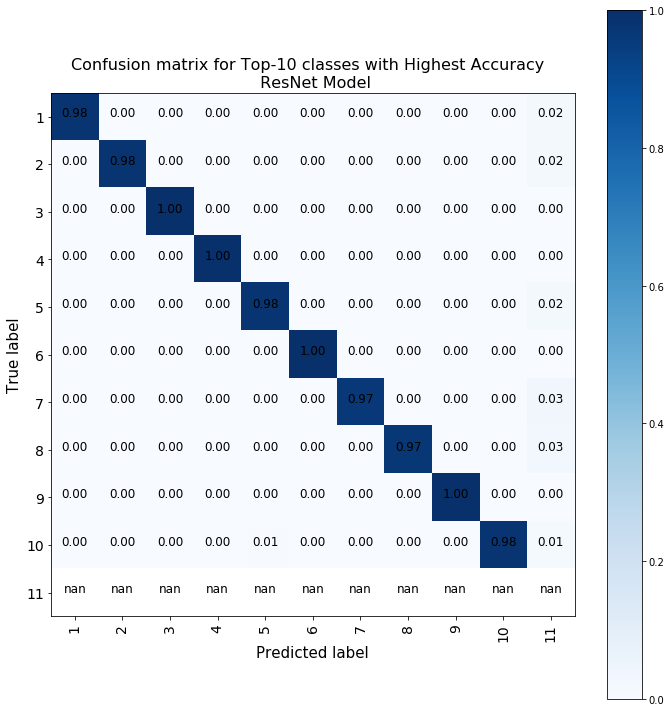

In [101]:
labelall_top_10 = list()
outputall_top_10 = list()


for i in range(len(labelall)):
    if (labelall[i] in set(considered_classes)):
        labelall_top_10.append(labelall[i])
        if (outputall[i] not in set(considered_classes)):
            outputall_top_10.append(200)
        else:
            outputall_top_10.append(outputall[i])
        

# Compute confusion matrix
cnf_matrix_top_10 = confusion_matrix(labelall_top_10, outputall_top_10)
np.set_printoptions(precision=4)

class_names_top_10 = [class_names[item] for item in considered_classes]
class_names_top_10.append('All others')
class_names_top_10_disp = [i + 1 for i in range(len(class_names_top_10))]
# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_top_10, classes=class_names_top_10_disp, normalize=True,
                      title='Confusion Matrix for Top-10 classes with Highest Accuracy  \n ResNet Model')

plt.show()

#### Confusion Matrix for Bottom-10 Correct Classification

In [124]:
labelall_bottom_10 = list()
outputall_bottom_10 = list()


for i in range(len(labelall)):
    if (labelall[i] in set(considered_classes)):
        labelall_bottom_10.append(labelall[i])
#         if (outputall[i] not in set(considered_classes)):
#             outputall_bottom_10.append(200)
#         else:
        outputall_bottom_10.append(outputall[i])

considered_classes = sorted(set(bottom_10))
print(considered_classes)
for i in range(len(considered_classes)):
    if considered_classes[i] >= indent_num:
        considered_classes[i] += 1
    
        
considered_classes = sorted(considered_classes + list(set(outputall_bottom_10)))
considered_classes


[1, 10, 15, 34, 115]


[1, 10, 15, 16, 18, 27, 30, 35, 49, 58, 62, 97, 106, 112, 116, 120]

In [74]:
print(class_names[116])

ephyra


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[0.     0.     0.     0.5    0.     0.     0.     0.     0.25   0.
  0.25   0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.3333 0.     0.     0.     0.3333
  0.     0.     0.3333 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     1.     0.     0.     0.     0.    ]
 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
     nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
     nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
     nan    nan    nan    nan    nan    nan]
 [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
     nan    nan    nan    nan    nan    nan]
 [0.     0.     0.     0.     0.3333 0.     0.     0.     0.     0.
  0.     0.     0.     0.3333 0.     0.3333]
 [   nan    nan    nan    nan    nan    nan    n

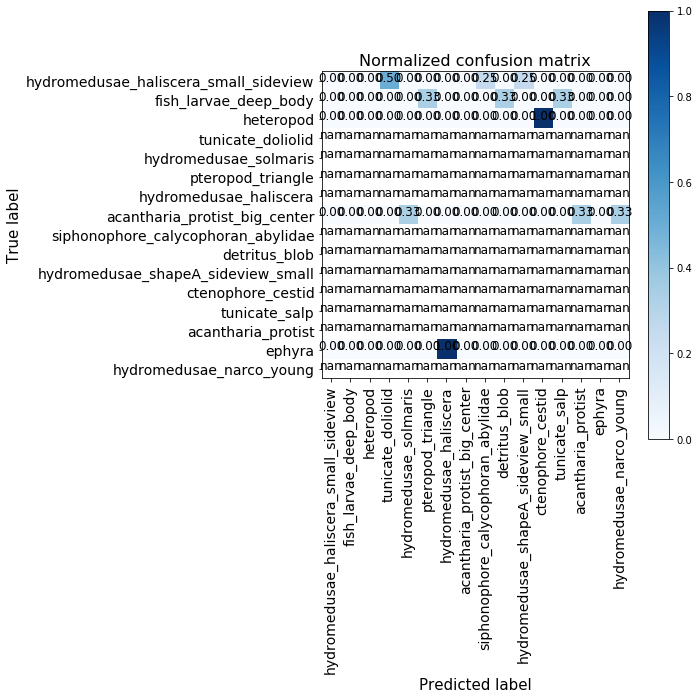

In [125]:
# Compute confusion matrix
cnf_matrix_bottom_10 = confusion_matrix(labelall_bottom_10, outputall_bottom_10)

np.set_printoptions(precision=4)

class_names_bottom_10 = [class_names[item] for item in considered_classes]
# class_names_bottom_10.append('All others')
# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix_bottom_10, classes=class_names_bottom_10, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [143]:
# import seaborn as sns;

# bottom_5_class_name = class_names_bottom_10[:3]
# bottom_5_class_name.append(class_names_bottom_10[7])
# bottom_5_class_name.append(class_names_bottom_10[14])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5,270.144,'Classes Confused with')

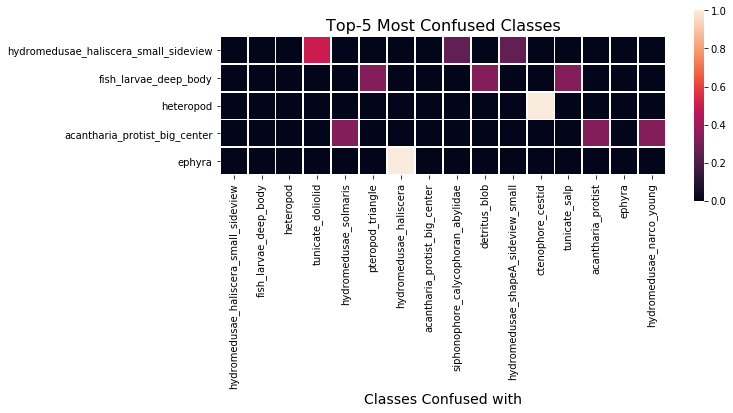

In [158]:
# cnf_matrix_bottom_10_norm = cnf_matrix_bottom_10.astype('float') / cnf_matrix_bottom_10.sum(axis=1)[:, np.newaxis]
# most_confused = np.vstack((cnf_matrix_bottom_10_norm[0:3,:], cnf_matrix_bottom_10_norm[7,:], cnf_matrix_bottom_10_norm[14,:]))
# plt.figure(figsize=(10,10))
# sns.heatmap(most_confused, 
#             xticklabels=class_names_bottom_10, 
#             yticklabels=bottom_5_class_name, 
#             linewidths=1,
#             linecolor='white',
#             square=True,
#             cbar_kws={"shrink": .35})
# plt.title('Top-5 Most Confused Classes', fontsize=16)
# plt.xlabel('Classes Confused with', fontsize=14)




In [129]:
considered_classes

[1, 10, 15, 16, 18, 27, 30, 35, 49, 58, 62, 97, 106, 112, 116, 120]

In [ ]:
cnf_matrix_top_10

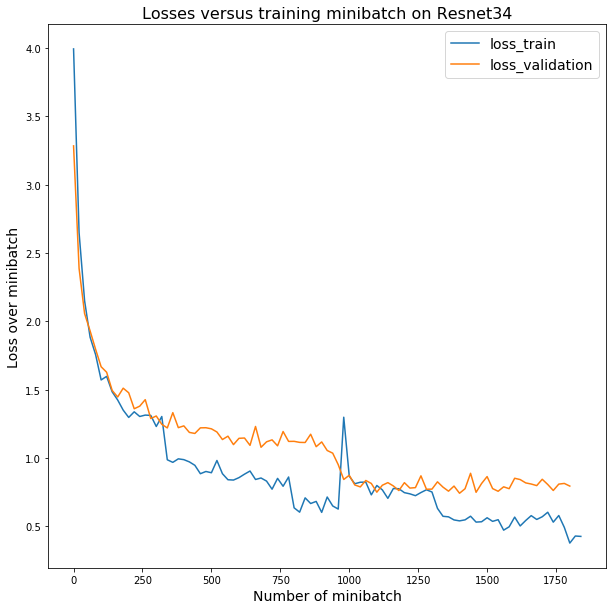

In [181]:
import numpy as np 
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt
import statistics
from os import listdir
from PIL import Image
N=20
M=20
def display_loss(loss_train,loss_vali):
    epc_train= []
    for i in range(len(loss_train)):
        epc_train.append(N*i)
    epc_val= []
    for i in range(len(loss_vali)):
        epc_val.append(M*i)
    plt.figure(figsize=(10,10))
    plt.plot(epc_train, loss_train, label='loss_train')
    plt.plot(epc_val, loss_vali, label='loss_validation')
    plt.title('Losses versus training minibatch on Resnet34',fontsize=16)
    plt.xlabel('Number of minibatch', fontsize=14)
    plt.ylabel('Loss over minibatch', fontsize=14)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1, fontsize=14)
    plt.show()
loss_train = np.load('./avg_train_loss.npy')
loss_val = np.load('./total_vali_loss.npy')
display_loss(loss_train,loss_val[0:-1])

In [204]:
len(loss_train)

93

In [205]:
len(np.convolve(loss_train, np.ones((5,)) / 5, mode='same'))

93

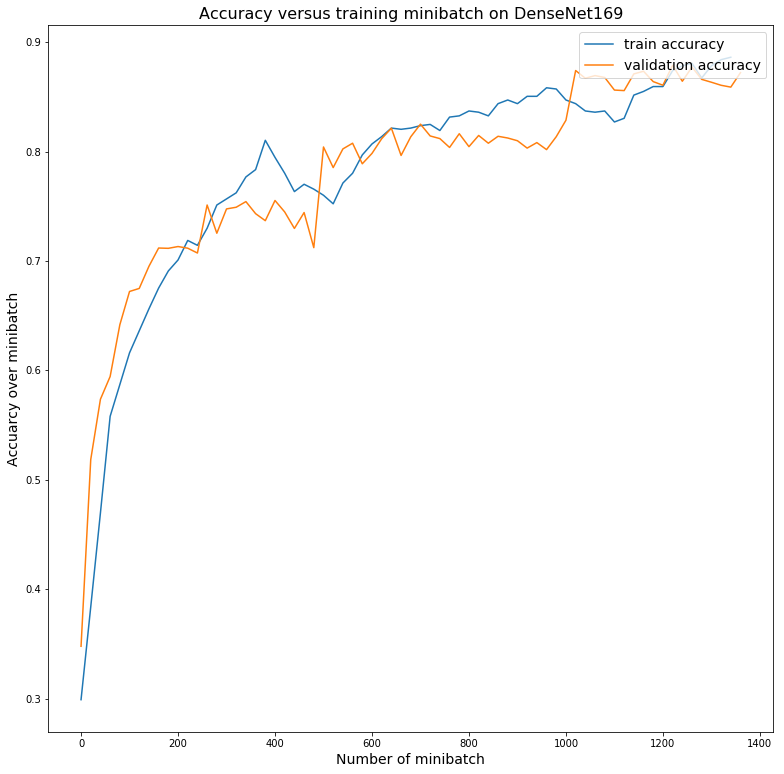

In [6]:
N=20
M=20
def display_accuracy(accu_train,accu_vali):
    epc_train= []
    for i in range(len(accu_train)):
        epc_train.append(N*i)
    epc_val= []
    for i in range(len(accu_vali)):
        epc_val.append(M*i)
    plt.figure(figsize=(13,13))
    plt.plot(epc_train, accu_train, label='train accuracy')
    plt.plot(epc_val, accu_vali, label='validation accuracy')
    plt.title('Accuracy versus training minibatch on DenseNet169',fontsize=16)
    plt.xlabel('Number of minibatch', fontsize=14)
    plt.ylabel('Accuarcy over minibatch', fontsize=14)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1, fontsize=14)
    plt.show()
loss_train = np.load('./avg_train_accuracy.npy')
loss_val = np.load('./total_vali_accuracy.npy')
display_accuracy(np.convolve(loss_train, np.ones((7,)) / 7, mode='same')[:-4],loss_val[0:-1])